# Example: quadratic line fitting (4)

A fourth example of how to use the calibration code with two disagreeing data sets with a different number of measurement locations in each data set.

In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle as pk
import subprocess
import shlex
import tempfile

In [2]:
# special imports
from utils import *

In [3]:
# pyplot settings
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["axes.titleweight"] = "bold"

## 1. Setup

In [4]:
# the model to fit
def f(x, a=-2, b=0, c=2):
    return a*(x - b)**2 + c

In [5]:
# lower and upper bounds for the parameters
a_low = -3; a_upp = -1
b_low = -0.1; b_upp = 0.1
c_low = 1; c_upp = 3

In [6]:
# data sets
ndata = 2

xdata = []
ydata = []
sdata = []

# first data set
xdata.append(np.array([0.5*x for x in range(5)]))
ydata.append(np.array([f(x, a=-1) for x in xdata[-1]]))
sdata.append(np.array([1/2 - f(x)/6 for x in xdata[-1]]))

# second data set
xdata.append(np.array([0.05*x for x in range(41) if not x % 10 == 0]))
ydata.append(np.array([f(x, a=-3) for x in xdata[-1]]))
sdata.append(np.array([1/2 - f(x)/6 for x in xdata[-1]]))

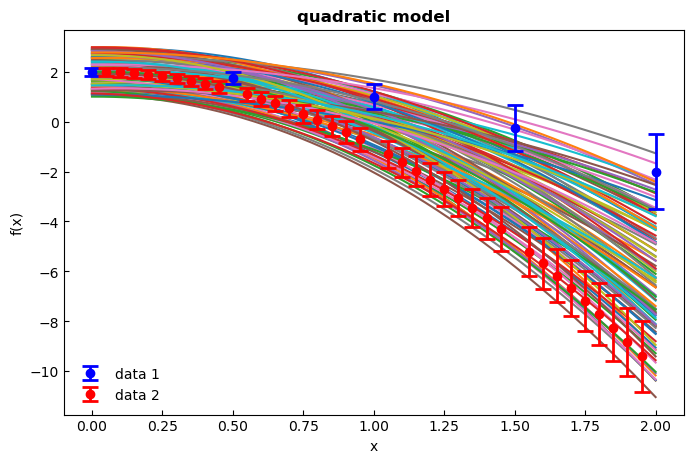

In [7]:
# plot model evaluations and data
x = np.linspace(0, 2)
n = 100
_, ax = plt.subplots(figsize=(8, 5))
for _ in range(n):
    a = (a_upp - a_low)*np.random.rand() + a_low
    b = (b_upp - b_low)*np.random.rand() + b_low
    c = (c_upp - c_low)*np.random.rand() + c_low
    ax.plot(x, f(x, a=a, b=b, c=c))
for j, color in enumerate(["blue", "red"]):
    ax.errorbar(xdata[j], ydata[j], yerr=sdata[j], color=color, linewidth=0, elinewidth=2, capsize=6, marker="o", capthick=2, zorder=100, label=f"data {j + 1}")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("quadratic model")
ax.legend(loc="lower left", frameon=False)
if save:
    plt.savefig(os.path.join(save_location, "example_4_quadratic.png"))
plt.show()

## 2. Surrogate construction

In [8]:
# construct surrogate models for each data set
results = []
for j in range(ndata):

    # generate data
    n = 1000
    xs = []
    ys = []
    for _ in range(n):
        a = (a_upp - a_low)*np.random.rand() + a_low
        b = (b_upp - b_low)*np.random.rand() + b_low
        c = (c_upp - c_low)*np.random.rand() + c_low
        xs.append([a, b, c])
        ys.append(f(xdata[j], a=a, b=b, c=c))
    xs = np.vstack(xs)
    ys = np.vstack(ys)

    # construct surrogate models
    with tempfile.TemporaryDirectory() as tmp:

        # save input and output data
        np.savetxt(os.path.join(tmp, "ptrain.dat"), xs)
        np.savetxt(os.path.join(tmp, "qtrain.dat"), xs)
        np.savetxt(os.path.join(tmp, "ytrain.dat"), ys)

        # save parameter ranges
        np.savetxt(os.path.join(tmp, "param_ranges.dat"), np.array([[a_low, a_upp], [b_low, b_upp], [c_low, c_upp]]))

        # run wibcs
        subprocess.run(shlex.split(f"{path_to_python} {path_to_uq_pc} -r offline_post -p param_ranges.dat -m lsq -n {xs.shape[0]} -s rand -t 2 -z"), cwd=tmp, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        # load results
        with open(os.path.join(tmp, "results.pk"), "rb") as file:
            results.append(pk.load(file))

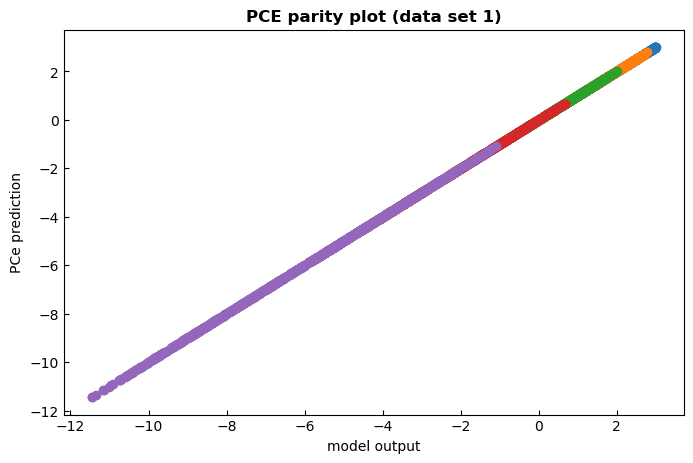

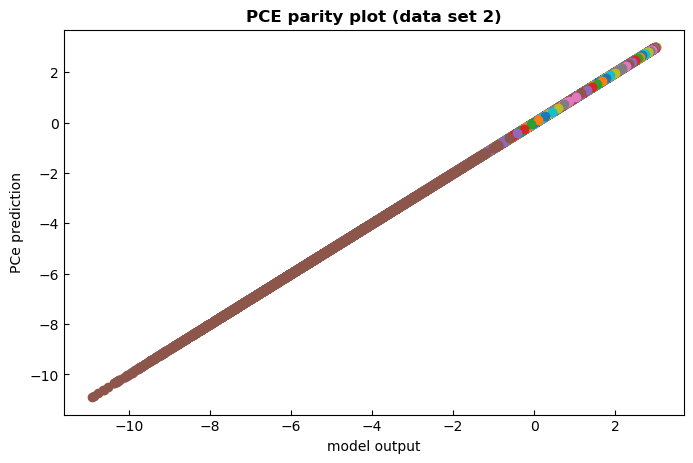

In [9]:
# plot PCE accuracy
for d in range(ndata):
    _, ax = plt.subplots(figsize=(8, 5))
    for i in range(len(results[d]["pcmi"][0])):
        ytrain = results[d]["training"][2][:, i]
        ytrain_pce = results[d]["training"][3][:, i]
        ax.scatter(ytrain, ytrain_pce)
    ax.set_xlabel("model output")
    ax.set_ylabel("PCe prediction")
    ax.set_title(f"PCE parity plot (data set {d + 1})")
    if save:
        plt.savefig(os.path.join(save_location, f"example_4_parity_{d + 1}.png"))
    plt.show()

## 3. Calibration

In [10]:
# perform calibration
with tempfile.TemporaryDirectory() as tmp:

    # save data mean and error bars
    for d in range(ndata):
        np.savetxt(os.path.join(tmp, f"data.{d + 1}.dat"), np.vstack([ydata[d], sdata[d]]).T)

    # save PCE coefficients and multi-indices
    for d in range(ndata):
        for n in range(len(results[d]["pcmi"][0])):
            np.savetxt(os.path.join(tmp, f"pccf.{d + 1}.{n + 1}.dat"), results[d]["pcmi"][0][n])
            np.savetxt(os.path.join(tmp, f"mindex.{d + 1}.{n + 1}.dat"), results[d]["pcmi"][1][n], fmt="%d")

    # save pushforward PCE coefficients and multi-indices
    for n in range(len(results[0]["pcmi"][0])):
        np.savetxt(os.path.join(tmp, f"pushforward.pccf.{10*n + 1}.dat"), results[0]["pcmi"][0][n])
        np.savetxt(os.path.join(tmp, f"pushforward.mindex.{10*n + 1}.dat"), results[0]["pcmi"][1][n], fmt="%d")
    for n in range(len(results[1]["pcmi"][0])):
        np.savetxt(os.path.join(tmp, f"pushforward.pccf.{n + 2 + (n // 9)}.dat"), results[1]["pcmi"][0][n])
        np.savetxt(os.path.join(tmp, f"pushforward.mindex.{n + 2 + (n // 9)}.dat"), results[1]["pcmi"][1][n], fmt="%d")

    # save prior
    with open(os.path.join(tmp, "prior.dat"), "w") as file:
        file.write(f"gaussian {(a_low + a_upp)/2} {(a_upp - a_low)/2}\n")
        file.write(f"gaussian {(b_low + b_upp)/2} {(b_upp - b_low)/2}\n")
        file.write(f"gaussian {(c_low + c_upp)/2} {(c_upp - c_low)/2}\n")

    # run calibration
    subprocess.run(shlex.split(path_to_dfi + " -v pushforward.pccf.{n}.dat -w pushforward.mindex.{n}.dat -g 0.1 -k 100 -m 0"), cwd=tmp)

    # load output files
    chain = np.loadtxt(os.path.join(tmp, "chain.dat"))
    pushforward = []
    n = 1
    pushforward_file = os.path.join(tmp, f"pushforward.1.{n}.dat")
    while os.path.isfile(pushforward_file):
        pushforward.append(np.loadtxt(pushforward_file))
        n += 1
        pushforward_file = os.path.join(tmp, f"pushforward.1.{n}.dat")
    synthetic_data = []
    for d in range(ndata):
        synthetic_data.append(np.loadtxt(os.path.join(tmp, f"synthetic.data.{d + 1}.dat")))

╭────────────────────────────────────────────────────╮
│                        dfi                         │
╰────────────────────────────────────────────────────╯
Found prior:
  => p1   : mu = -2        , sigma = 1         
  => p2   : mu = 0         , sigma = 0.1       
  => p3   : mu = 2         , sigma = 1         
Found 2 data sets:
  => Data set number 1/2:
       -> y1   = 2         s1   = 0.166667  
       -> y2   = 1.75      s2   = 0.25      
       -> y3   = 1         s3   = 0.5       
       -> y4   = -0.25     s4   = 0.916667  
       -> y5   = -2        s5   = 1.5       
  => Data set number 2/2:
       -> y1   = 1.9925    s1   = 0.1675    
       -> y2   = 1.97      s2   = 0.17      
       -> y3   = 1.9325    s3   = 0.174167  
       -> y4   = 1.88      s4   = 0.18      
       -> y5   = 1.8125    s5   = 0.1875    
       -> y6   = 1.73      s6   = 0.196667  
       -> y7   = 1.6325    s7   = 0.2075    
       -> y8   = 1.52      s8   = 0.22      
       -> y9   = 1.392

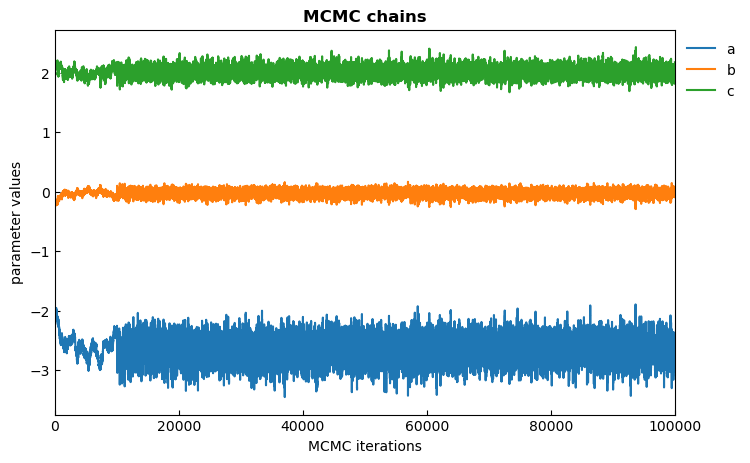

In [11]:
# plot MCMC chains
_, ax = plt.subplots(figsize=(8, 5))
for j, label in enumerate(["a", "b", "c"]):
    ax.plot(chain[:, j + 1], label=label)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set_xlabel("MCMC iterations")
ax.set_ylabel("parameter values")
ax.set_title("MCMC chains")
ax.set_xlim(0, chain.shape[0])
if save:    
    plt.savefig(os.path.join(save_location, "example_4_mcmc_chains.png"))
plt.show()

In [12]:
# get the MAP prediction
stacked_pushforward = np.vstack(pushforward).T
map_idx = np.argmax(chain[:, -1])
map_prediction = stacked_pushforward[map_idx, :]

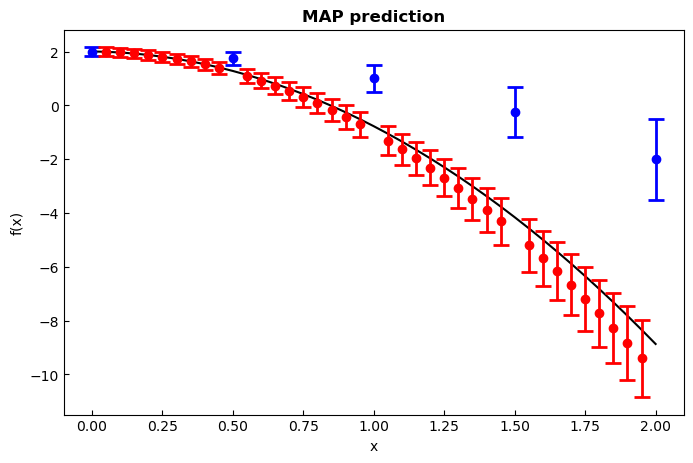

In [13]:
# plot MAP prediction
_, ax = plt.subplots(figsize=(8, 5))
xdata_ = np.sort(np.hstack([x for x in xdata]))
max_idx = np.argmax(chain[:, -1])
ax.plot(xdata_, map_prediction, color="black")
for j, color in enumerate(["blue", "red"]):
    ax.errorbar(xdata[j], ydata[j], yerr=sdata[j], color=color, linewidth=0, elinewidth=2, capsize=6, marker="o", capthick=2, zorder=100, label=f"data {j + 1}")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("MAP prediction")
if save:
    plt.savefig(os.path.join(save_location, "example_4_map_prediction.png"))
plt.show()

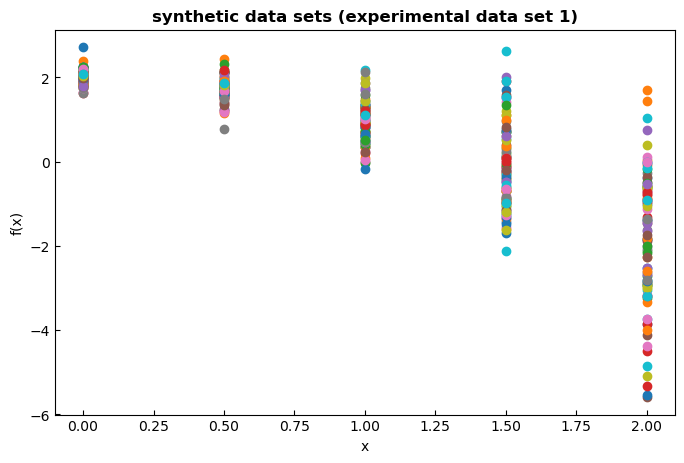

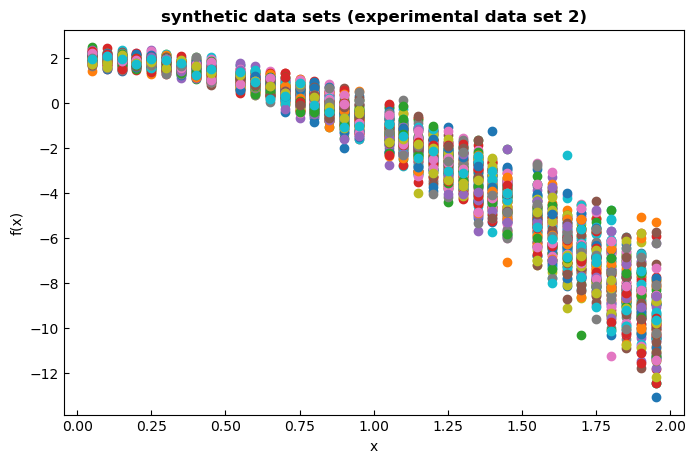

In [14]:
# plot sythetic data sets
for d in range(ndata):
    _, ax = plt.subplots(figsize=(8, 5))
    for i in range(synthetic_data[d].shape[1]):
        ax.scatter(xdata[d], synthetic_data[d][:, i])
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.set_title(f"synthetic data sets (experimental data set {d + 1})")
    if save:
        plt.savefig(os.path.join(save_location, f"example_4_synthetic_data_{d + 1}.png"))
    plt.show()

## 4. Weighted calibration

In [15]:
# perform calibration
with tempfile.TemporaryDirectory() as tmp:

    # save data mean and error bars
    for d in range(ndata):
        np.savetxt(os.path.join(tmp, f"data.{d + 1}.dat"), np.vstack([ydata[d], sdata[d]]).T)

    # save PCE coefficients and multi-indices
    for d in range(ndata):
        for n in range(len(results[d]["pcmi"][0])):
            np.savetxt(os.path.join(tmp, f"pccf.{d + 1}.{n + 1}.dat"), results[d]["pcmi"][0][n])
            np.savetxt(os.path.join(tmp, f"mindex.{d + 1}.{n + 1}.dat"), results[d]["pcmi"][1][n], fmt="%d")

    # save pushforward PCE coefficients and multi-indices
    for n in range(len(results[0]["pcmi"][0])):
        np.savetxt(os.path.join(tmp, f"pushforward.pccf.{10*n + 1}.dat"), results[0]["pcmi"][0][n])
        np.savetxt(os.path.join(tmp, f"pushforward.mindex.{10*n + 1}.dat"), results[0]["pcmi"][1][n], fmt="%d")
    for n in range(len(results[1]["pcmi"][0])):
        np.savetxt(os.path.join(tmp, f"pushforward.pccf.{n + 2 + (n // 9)}.dat"), results[1]["pcmi"][0][n])
        np.savetxt(os.path.join(tmp, f"pushforward.mindex.{n + 2 + (n // 9)}.dat"), results[1]["pcmi"][1][n], fmt="%d")

    # save prior
    with open(os.path.join(tmp, "prior.dat"), "w") as file:
        file.write(f"gaussian {(a_low + a_upp)/2} {(a_upp - a_low)/2}\n")
        file.write(f"gaussian {(b_low + b_upp)/2} {(b_upp - b_low)/2}\n")
        file.write(f"gaussian {(c_low + c_upp)/2} {(c_upp - c_low)/2}\n")

    # run calibration
    subprocess.run(shlex.split(path_to_dfi + " -v pushforward.pccf.{n}.dat -w pushforward.mindex.{n}.dat -g 0.1 -k 100 -m 0 -j data_size"), cwd=tmp)

    # load output files
    chain = np.loadtxt(os.path.join(tmp, "chain.dat"))
    pushforward = []
    n = 1
    pushforward_file = os.path.join(tmp, f"pushforward.1.{n}.dat")
    while os.path.isfile(pushforward_file):
        pushforward.append(np.loadtxt(pushforward_file))
        n += 1
        pushforward_file = os.path.join(tmp, f"pushforward.1.{n}.dat")
    synthetic_data = []
    for d in range(ndata):
        synthetic_data.append(np.loadtxt(os.path.join(tmp, f"synthetic.data.{d + 1}.dat")))

╭────────────────────────────────────────────────────╮
│                        dfi                         │
╰────────────────────────────────────────────────────╯
Found prior:
  => p1   : mu = -2        , sigma = 1         
  => p2   : mu = 0         , sigma = 0.1       
  => p3   : mu = 2         , sigma = 1         
Found 2 data sets:
  => Data set number 1/2:
       -> y1   = 2         s1   = 0.166667  
       -> y2   = 1.75      s2   = 0.25      
       -> y3   = 1         s3   = 0.5       
       -> y4   = -0.25     s4   = 0.916667  
       -> y5   = -2        s5   = 1.5       
  => Data set number 2/2:
       -> y1   = 1.9925    s1   = 0.1675    
       -> y2   = 1.97      s2   = 0.17      
       -> y3   = 1.9325    s3   = 0.174167  
       -> y4   = 1.88      s4   = 0.18      
       -> y5   = 1.8125    s5   = 0.1875    
       -> y6   = 1.73      s6   = 0.196667  
       -> y7   = 1.6325    s7   = 0.2075    
       -> y8   = 1.52      s8   = 0.22      
       -> y9   = 1.392

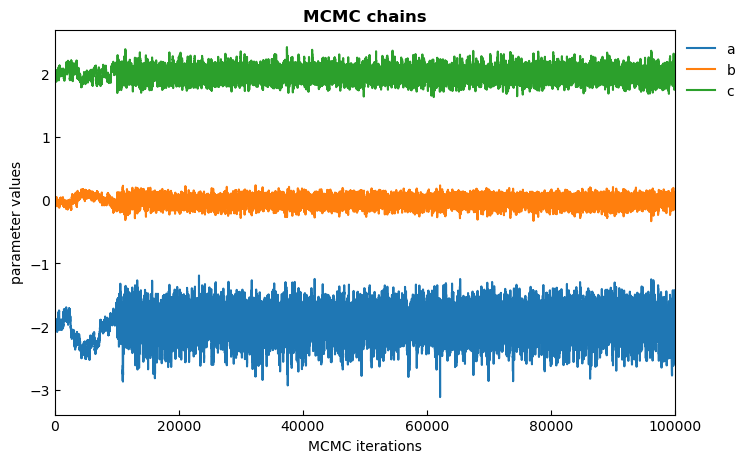

In [16]:
# plot MCMC chains
_, ax = plt.subplots(figsize=(8, 5))
for j, label in enumerate(["a", "b", "c"]):
    ax.plot(chain[:, j + 1], label=label)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set_xlabel("MCMC iterations")
ax.set_ylabel("parameter values")
ax.set_title("MCMC chains")
ax.set_xlim(0, chain.shape[0])
if save:    
    plt.savefig(os.path.join(save_location, "example_4_mcmc_chains_weighted.png"))
plt.show()

In [17]:
# get the MAP prediction
stacked_pushforward = np.vstack(pushforward).T
map_idx = np.argmax(chain[:, -1])
map_prediction = stacked_pushforward[map_idx, :]

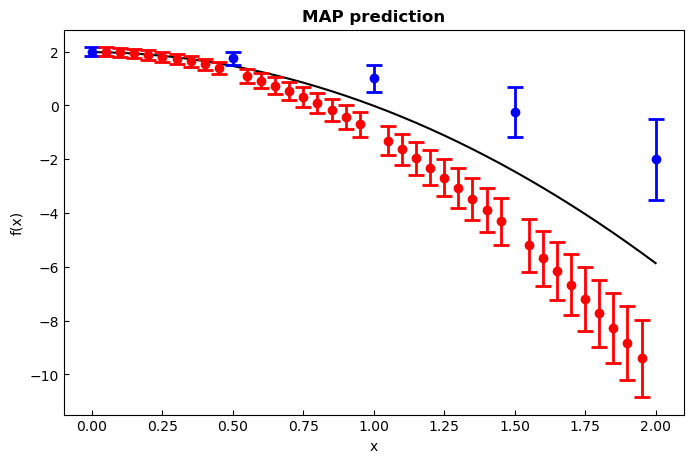

In [18]:
# plot MAP prediction
_, ax = plt.subplots(figsize=(8, 5))
xdata_ = np.sort(np.hstack([x for x in xdata]))
max_idx = np.argmax(chain[:, -1])
ax.plot(xdata_, map_prediction, color="black")
for j, color in enumerate(["blue", "red"]):
    ax.errorbar(xdata[j], ydata[j], yerr=sdata[j], color=color, linewidth=0, elinewidth=2, capsize=6, marker="o", capthick=2, zorder=100, label=f"data {j + 1}")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("MAP prediction")
if save:
    plt.savefig(os.path.join(save_location, "example_4_map_prediction_weighted.png"))
plt.show()